### Load & Merge

In [7]:
import pandas as pd

# 1. Load
a1 = pd.read_csv('annex1.csv')   # Item master (optional)
a2 = pd.read_csv('annex2.csv', parse_dates=['Date'])
a3 = pd.read_csv('annex3.csv', parse_dates=['Date'])
a4 = pd.read_csv('annex4.csv')

# 2. Clean Annex2
a2 = a2.drop_duplicates()                        # drop the 212 dupes
a2['Quantity'] = a2['Quantity Sold (kilo)']
a2['UnitPrice_RMB'] = a2['Unit Selling Price (RMB/kg)']
a2['IsReturn'] = (a2['Sale or Return'] == 'Return')

# 3. Merge in cost data from Annex3
df = a2.merge(a3[['Date','Item Code','Wholesale Price (RMB/kg)']],
              on=['Date','Item Code'], how='left')

###  (Compute fields) Quantity, Sales_INR, Cost_INR, Margin, Return flag

In [8]:
# 1. Merge in loss‐rate from Annex4
df = df.merge(a4[['Item Code','Loss Rate (%)']], on='Item Code', how='left')

# 2. Compute Sales, Cost, Margin
RMB_to_INR = 12.3  # adjust to current rate
df['Sales_INR'] = df['Quantity'] * df['UnitPrice_RMB'] * RMB_to_INR

# wholesale cost adjusted for loss
df['Cost_RMB'] = df['Quantity'] * df['Wholesale Price (RMB/kg)'] \
                 * (1 + df['Loss Rate (%)']/100)
df['Cost_INR'] = df['Cost_RMB'] * RMB_to_INR

df['Margin_INR'] = df['Sales_INR'] - df['Cost_INR']
df['ReturnRate'] = df['Quantity'].where(df['IsReturn'], 0) / df['Quantity']

# 3. (Optional) bring in item names/categories
df = df.merge(a1[['Item Code','Item Name','Category Name']],
              on='Item Code', how='left')

### Quick peek at final schema

In [13]:
df.head()

,Date,Time,Item Code,Quantity Sold (kilo),Unit Selling Price (RMB/kg),Sale or Return,Discount (Yes/No),Quantity,UnitPrice_RMB,IsReturn,Wholesale Price (RMB/kg),Loss Rate (%),Sales_INR,Cost_RMB,Cost_INR,Margin_INR,ReturnRate,Item Name,Category Name,Month
0,2020-01-07,15:07.9,1.029000e+14,0.396,7.6,sale,No,0.396,7.6,False,4.32,7.08,37.01808,1.831839,22.531619,14.486461,0.0,Paopaojiao (Jingpin),Capsicum,January
1,2020-01-07,17:27.3,1.029000e+14,0.849,3.2,sale,No,0.849,3.2,False,2.10,22.27,33.41664,2.179952,26.813408,6.603232,0.0,Chinese Cabbage,Flower/Leaf Vegetables,January
2,2020-01-07,17:33.9,1.029000e+14,0.409,7.6,sale,No,0.409,7.6,False,4.32,7.08,38.23332,1.891975,23.271294,14.962026,0.0,Paopaojiao (Jingpin),Capsicum,January
3,2020-01-07,19:45.4,1.029000e+14,0.421,10.0,sale,No,0.421,10.0,False,7.03,14.43,51.78300,3.386705,41.656467,10.126533,0.0,Shanghaiqing,Flower/Leaf Vegetables,January
4,2020-01-07,20:23.7,1.029000e+14,0.539,8.0,sale,No,0.539,8.0,False,4.60,13.70,53.03760,2.819078,34.674657,18.362943,0.0,Caixin,Flower/Leaf Vegetables,January


### Bar chart of return spikes

Monthly returns:
 Month
January      -8.069
February     -6.894
March        -9.615
April        -7.359
May          -8.839
June         -8.750
July        -16.981
August      -14.380
September    -9.878
October     -15.244
November     -3.772
December     -7.536
Name: Quantity, dtype: float64


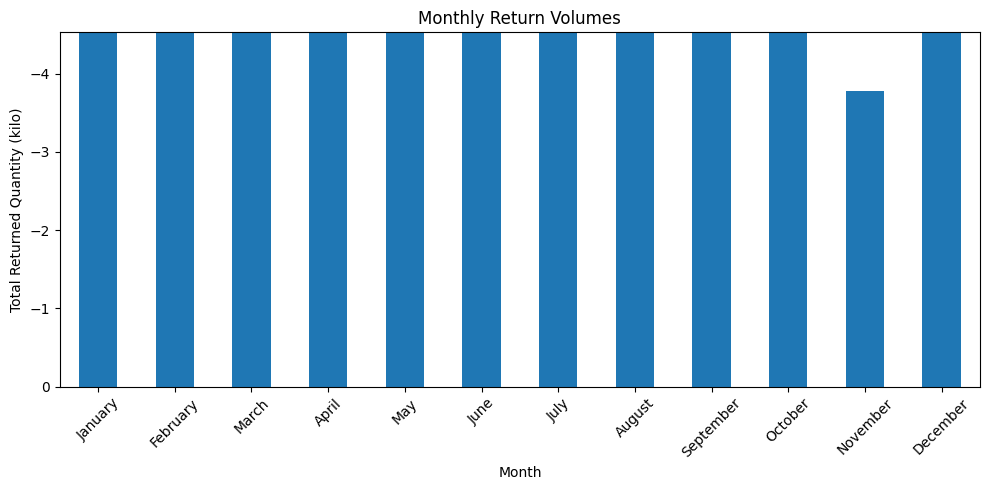

In [14]:
# 1. Re‑flag returns more robustly
df['IsReturn'] = df['Sale or Return'].astype(str).str.strip().str.lower() == 'return'

# 2. Re‑compute monthly_returns
df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month_name()
month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]
monthly_returns = (
    df[df['IsReturn']]
      .groupby('Month')['Quantity']
      .sum()
      .reindex(month_order)
      .fillna(0)
)

print("Monthly returns:\n", monthly_returns)

# 3. Plot with y‑limit
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax = monthly_returns.plot(kind='bar', title='Monthly Return Volumes')
ax.set_ylim(0, monthly_returns.max() * 1.2)
plt.ylabel('Total Returned Quantity (kilo)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sales vs Returns line chart

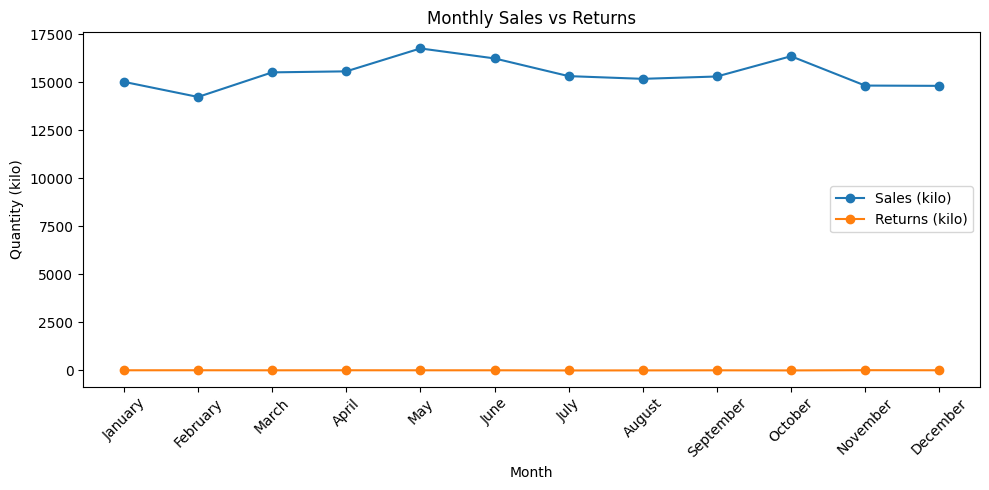

In [15]:
monthly_sales = df.groupby('Month')['Quantity'].sum().reindex(month_order)
monthly_returns = df[df['IsReturn']].groupby('Month')['Quantity'].sum().reindex(month_order)

plt.figure(figsize=(10,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', label='Sales (kilo)')
plt.plot(monthly_returns.index, monthly_returns.values, marker='o', label='Returns (kilo)')
plt.title('Monthly Sales vs Returns')
plt.xlabel('Month')
plt.ylabel('Quantity (kilo)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Boxplot of discounted vs full‑price margins

C:\Users\Asus\AppData\Local\Temp\ipykernel_5696\3739414547.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m_full.dropna(), m_disc.dropna()],


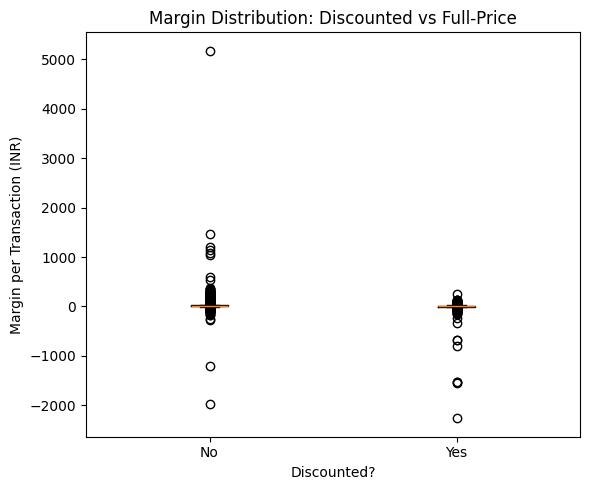

In [16]:
import matplotlib.pyplot as plt

# 1. Split your Margin_INR into two groups
m_full  = df.loc[df['Discount (Yes/No)'] == 'No',  'Margin_INR']
m_disc  = df.loc[df['Discount (Yes/No)'] == 'Yes', 'Margin_INR']

# 2. Plot side‑by‑side boxplots
plt.figure(figsize=(6,5))
plt.boxplot([m_full.dropna(), m_disc.dropna()],
            labels=['No', 'Yes'])
plt.title('Margin Distribution: Discounted vs Full‑Price')
plt.ylabel('Margin per Transaction (INR)')
plt.xlabel('Discounted?')
plt.tight_layout()
plt.show()

### Top 5 categories by return rate

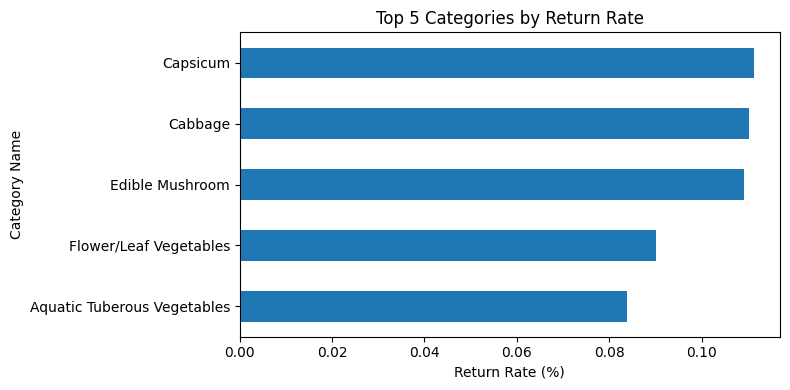

In [17]:
cat = (
    df.groupby('Category Name')
      .agg(TotalSold=('Quantity','sum'),
           Returns=('IsReturn','sum'))
)
cat['ReturnRatePct'] = 100 * cat['Returns'] / cat['TotalSold']
top5_cat = cat.sort_values('ReturnRatePct', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(8,4))
top5_cat['ReturnRatePct'].plot(kind='barh', ax=ax, title='Top 5 Categories by Return Rate')
ax.set_xlabel('Return Rate (%)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 10 worst‑margin SKUs

In [18]:
worst_skus = (
    df.groupby(['Item Code', 'Item Name'])
      .agg(MarginSum=('Margin_INR','sum'))
      .sort_values('MarginSum')
      .head(10)
      .reset_index()
)
display(worst_skus)

,Item Code,Item Name,MarginSum
0,1.029000e+14,Hongshan Gift Box,-4602.660000
1,1.029000e+14,Hongshan Shoutidai,-2164.800000
2,1.029000e+14,Hongshan Caitai,-659.082831
3,1.029000e+14,Chicken Fir Bacteria,-205.397208
4,1.029000e+14,Caidian Quinoa Artemisia (Bag),-138.904454
5,1.029000e+14,Round Eggplant (1),-96.420933
6,1.029000e+14,Big Broccoli,-77.819637
7,1.029000e+14,Huanghuacai,-42.732540
8,1.029000e+14,White Jelly Mushroom,19.263030
9,1.029000e+14,Fruit Pepper (Orange),19.979013
